In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten

In [3]:
dataset_dir = "/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset"

In [4]:
image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))

In [10]:
image_paths = image_paths[:500]

In [11]:
def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.crop((0, 20, 178, 198))
    img = img.resize(target_size)
    img = np.array(img)/127.5 - 1
    return img

In [12]:
dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

In [13]:
print(dataset.shape)

(200, 64, 64, 3)


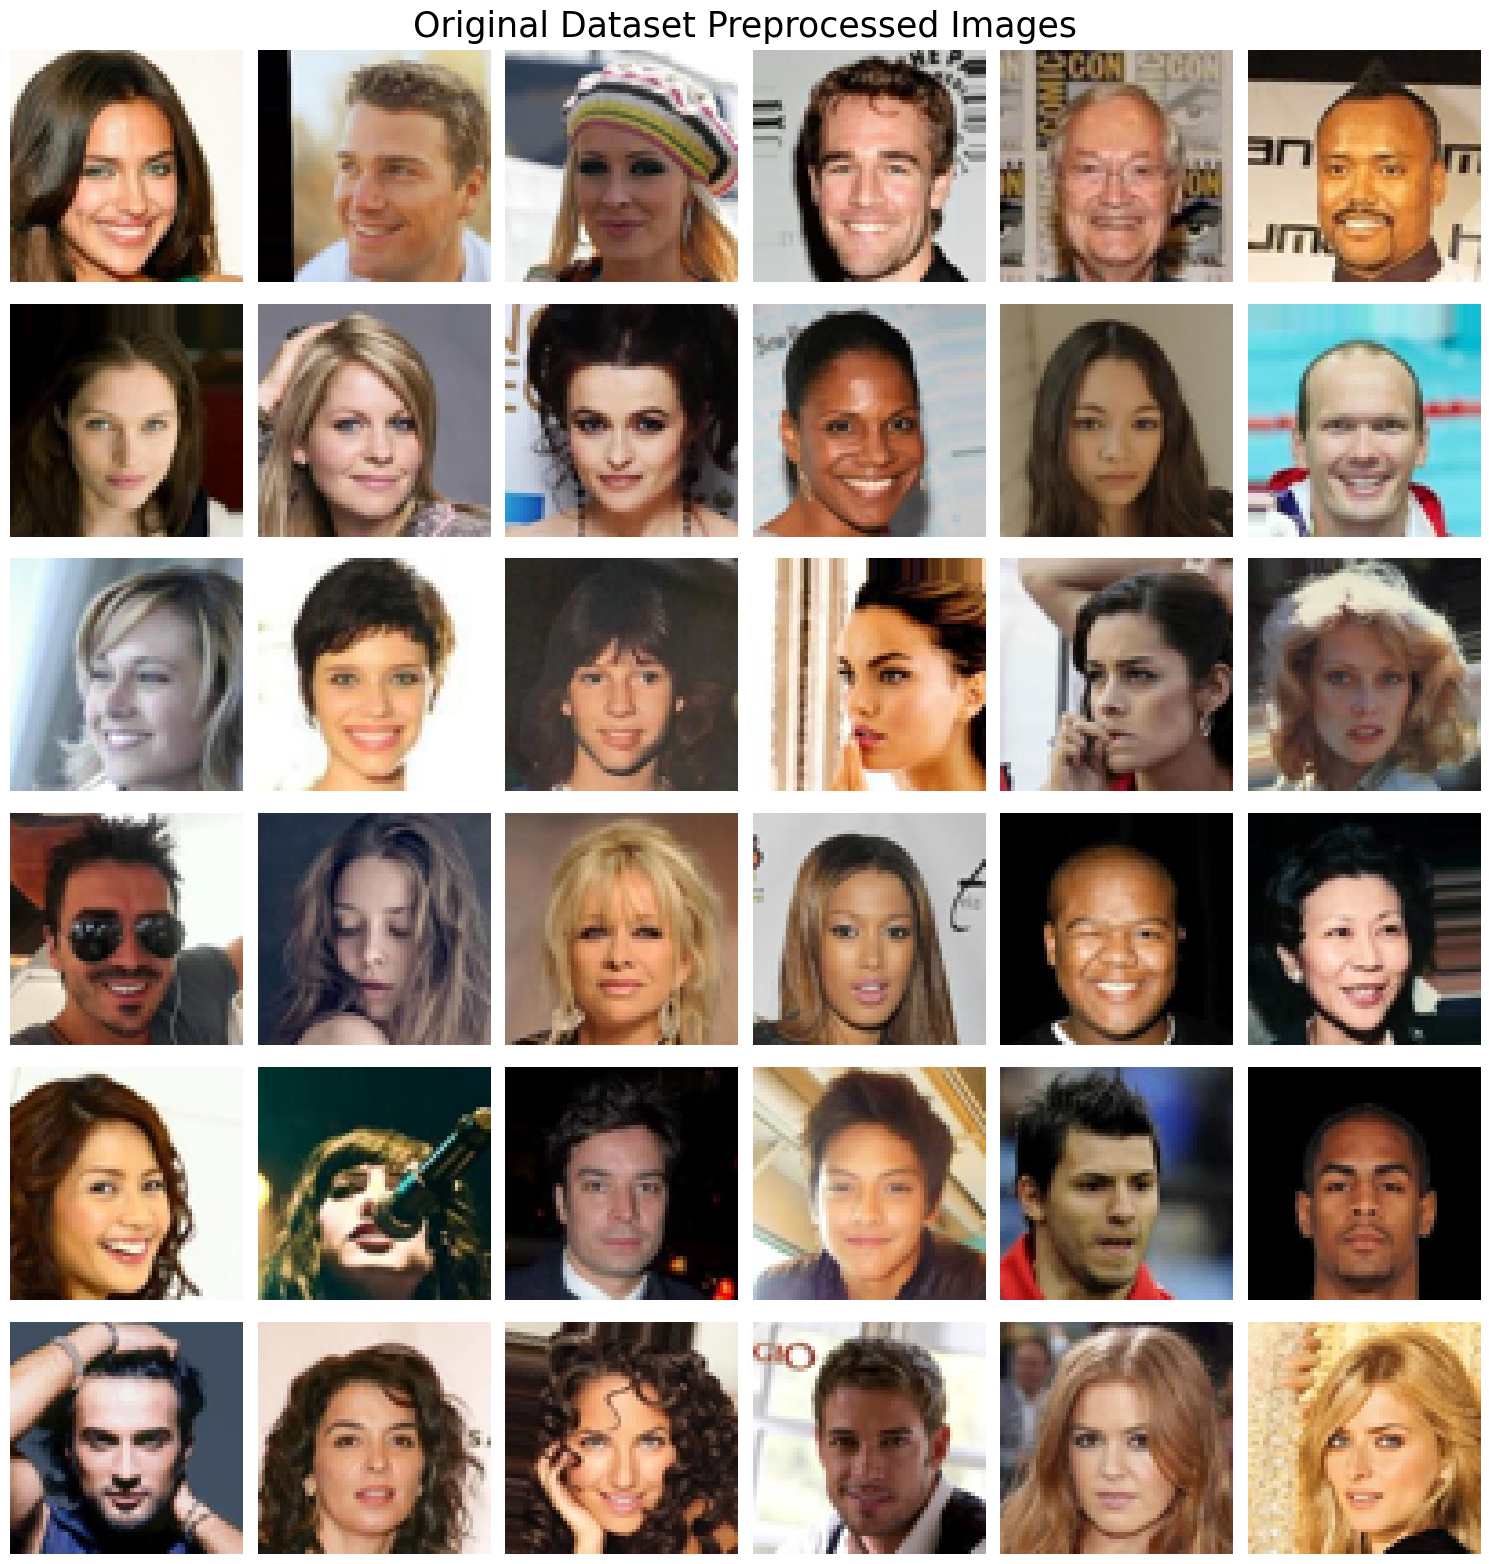

In [14]:
fig, axes = plt.subplots(6, 6, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    img = dataset[i]
    img_rescaled = (img + 1) / 2
    ax.imshow(img_rescaled)
    ax.axis('off')

fig.suptitle('Original Dataset Preprocessed Images', fontsize=25)

plt.tight_layout()
plt.show()

In [15]:
# generator
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(3, (4, 4), activation='tanh', padding='same'))
    return model

In [16]:
# discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [17]:
latent_dim = 100

# Build and compile the discriminator
discriminator = build_discriminator((64, 64, 3))
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,201 (1.48 MB)

 Trainable params: 387,201 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
generator = build_generator(latent_dim)
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,400,195 (5.34 MB)

 Trainable params: 1,400,195 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
generator = build_generator(latent_dim)

# The generator takes noise as input and generates images
z = layers.Input(shape=(latent_dim,))
img = generator(z)

In [20]:
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = models.Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# **Running for 100 epochs**

In [21]:
# Define a function to train the GAN
def train_gan(generator, discriminator, combined, images, latent_dim, epochs=100, batch_size=128):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)
        
        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, real)
        
        print(f"Epoch {epoch+1}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

# Train the GAN
train_gan(generator, discriminator, combined, dataset, latent_dim, epochs=100, batch_size=128)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


I0000 00:00:1712416795.107735    3081 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1, Discriminator Loss: 0.6878421306610107, Generator Loss: 0.6931185722351074
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 2, Discriminator Loss: 0.6901578903198242, Generator Loss: 0.6928411722183228
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 3, Discriminator Loss: 0.6893880367279053, Generator Loss: 0.6925584673881531
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 4, Discriminator Loss: 0.6898149847984314, Generator Loss: 0.6922430396080017
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Epoch 5, Discriminator Loss: 0.6897453665733337, Generator Loss: 0.6918485760688782
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 6, Discriminator Loss: 0.6901408433914185, Generator Loss: 0.6913642287254333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 7, Discriminator Loss: 0.6901916265487671, Generator Loss: 0.690775990486145
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 8, Discriminator Loss: 0.6902657747268677, Generator Loss: 0.6900598406791687
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 9, Discriminator Lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


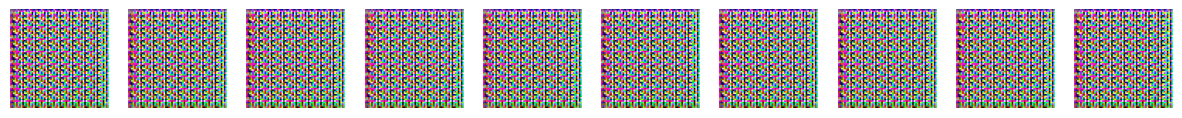

In [22]:
import matplotlib.pyplot as plt

# Function to generate and display images
def generate_and_display_images(generator, latent_dim, num_samples=10):
    # Generate random noise
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    
    generated_images = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2
    
    plt.figure(figsize=(15, 16))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

generate_and_display_images(generator, latent_dim, num_samples=10)

# **Running for 200 epochs**

In [ ]:
train_gan(generator, discriminator, combined, dataset, latent_dim, epochs=100, batch_size=256)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 1, Discriminator Loss: 0.9338306188583374, Generator Loss: 0.3939128816127777
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 2, Discriminator Loss: 0.9355188608169556, Generator Loss: 0.3924620449542999
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 3, Discriminator Loss: 0.9372014999389648, Generator Loss: 0.39103180170059204
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 4, Discriminator Loss: 0.9388855695724487, Generator Loss: 0.38962647318840027
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 5, Discriminator Loss: 0.9405728578567505, Generator Loss: 0.3882088363170624
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 6, Discriminator Loss: 0.9422187805175781, Generator Loss: 0.38680580258369446
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 7, Discriminator Loss: 0.9438619613647461, Generator Loss: 0.3854144811630249
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Epoch 8, Discriminator Loss: 0.9455522298812866, Generator Loss: 0.38400718569755554
8/8 ━━━━━━━━━━━━━━━━━━━